Use Efficientnet classifier example as a base to test SIFT.
Chop each 256x256 dog picture into 49 overlapping 65x65 patches.
SIFT each patch, concatenate all descriptors together,
take the average value for each angular bin, and push that through an accordion-style Dense/FFN network.

Accuracy is terrible, but the training acts like a normal network.

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
import keras

In [ ]:
!pip uninstall -y keras-sift
!pip install -qq git+https://github.com/LanceNorskog/keras-sift.git
from keras_sift import getSIFTModel

In [ ]:
IMG_SIZE = 256
PATCH_SIZE = 65
NUM_ANG_BINS = 8
NUM_SPATIAL_BINS = 4

import tensorflow_datasets as tfds

batch_size = 64

dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes

size = (IMG_SIZE, IMG_SIZE)
ds_sample = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_train_orig = ds_train.map(lambda image, label: (tf.image.rgb_to_grayscale(tf.image.resize(image, size)) / 255, label))
ds_test_orig = ds_test.map(lambda image, label: (tf.image.rgb_to_grayscale(tf.image.resize(image, size)) / 255, label))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete5RM7BK/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incomplete5RM7BK/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [ ]:
def reset_random_seeds(seed=2):
   os.environ['PYTHONHASHSEED']=str(seed)
   tf.random.set_seed(seed)
   np.random.seed(seed)
   random.seed(seed)


Break image into overlapping patches

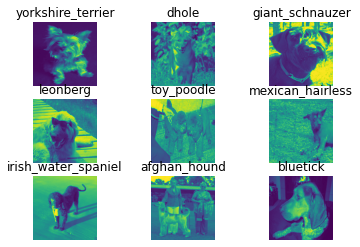

In [ ]:
import matplotlib.pyplot as plt

def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]

label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train_orig.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    dog = image.numpy().astype("uint8")
    gray = np.reshape(image.numpy(), (IMG_SIZE, IMG_SIZE))
    plt.imshow(gray)
    plt.title("{}".format(format_label(label)))
    plt.axis("off")


In [ ]:
chopped = [[
  [[0,0],[65,65]],
  [[0,33],[65,64+33]],
  [[0,64],[65,64+65]],
  [[0,96],[65,96+65]],
  [[0,128],[65,128+65]],
  [[0,160],[65,160+65]],
  [[0,192],[65,192+64]],
  ], [
  [[32,0],[65+32,65]],
  [[32,33],[65+32,65+32]],
  [[32,64],[65+32,64+65]],
  [[32,96],[65+32,96+65]],
  [[32,128],[65+32,128+65]],
  [[32,160],[65+32,160+65]],
  [[32,192],[65+32,192+65]],
  ], [

  [[64,0],[65+64,65]],
  [[64,33],[65+64,65+32]],
  [[64,64],[65+64,64+65]],
  [[64,96],[65+64,96+65]],
  [[64,128],[65+64,128+65]],
  [[64,160],[65+64,160+65]],
  [[64,192],[65+64,192+65]],
  ], [

  [[96,0],[65+96,65]],
  [[96,33],[65+96,65+32]],
  [[96,64],[65+96,64+65]],
  [[96,96],[65+96,96+65]],
  [[96,128],[65+96,128+65]],
  [[96,160],[65+96,160+65]],
  [[96,192],[65+96,192+65]],
  ], [

  [[128,0],[65+128,65]],
  [[128,33],[65+128,65+32]],
  [[128,64],[65+128,64+65]],
  [[128,96],[65+128,96+65]],
  [[128,128],[65+128,128+65]],
  [[128,160],[65+128,160+65]],
  [[128,192],[65+128,192+65]],
  ], [

  [[160,0],[65+160,65]],
  [[160,33],[65+160,65+32]],
  [[160,64],[65+160,64+65]],
  [[160,96],[65+160,96+65]],
  [[160,128],[65+160,128+65]],
  [[160,160],[65+160,160+65]],
  [[160,192],[65+160,192+65]],
  ], [

  [[192,0],[65+192,65]],
  [[192,33],[65+192,65+32]],
  [[192,64],[65+192,64+65]],
  [[192,96],[65+192,96+65]],
  [[192,128],[65+192,128+65]],
  [[192,160],[65+192,160+65]],
  [[192,192],[65+192,192+65]],
  ]
]

lo = 0
hi = 6

def get_max():
    return len(chopped), len(chopped[0])

def get_offsets(ix, iy):
    p = chopped[ix][iy]
    return p[0][0], p[0][1]

def get_patches():
    for i, row in enumerate(np.array(chopped, dtype='int32')):
        # print(i, row)
        if i < lo or i > hi:
            continue
        for j, col in enumerate(row):
            # print(j, col)
            if j < lo or j > hi:
                continue
            offx, offy = get_offsets(i, j)
            # print(i, j, offx, offy)
            if offx + PATCH_SIZE >= IMG_SIZE:
                offx = (IMG_SIZE - 1) - PATCH_SIZE
            if offy + PATCH_SIZE >= IMG_SIZE:
                offy = (IMG_SIZE - 1) - PATCH_SIZE
            yield (i, j, offx, offy)


get_offsets(3,2)

(96, 64)

Chop an image into overlapping patches

In [ ]:
for i, (image, label) in enumerate(ds_train_orig.take(1)):
    full = np.reshape(image.numpy(), (IMG_SIZE, IMG_SIZE, 1))


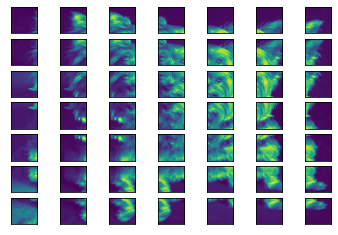

In [ ]:
import matplotlib.pyplot as plt

rows, cols = get_max()

fig,axes = plt.subplots(rows, cols, squeeze=False)

for i, j, offx, offy in get_patches():
    patch = tf.image.crop_to_bounding_box(full, offx, offy, PATCH_SIZE, PATCH_SIZE)
    axes[i,j].set_xticks([])
    axes[i,j].set_yticks([])
    axes[i,j].imshow(np.resize(patch, (PATCH_SIZE, PATCH_SIZE)))

plt.show()

Prep data

In [ ]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train_orig.map(
    input_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test_orig.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)


In [ ]:

patches_train = ds_train.map(lambda image, label: (tuple([
    tf.image.crop_to_bounding_box(image, offx, offy, PATCH_SIZE, PATCH_SIZE)
        for _, _, offx, offy in get_patches()
    ]), 
    label))

patches_test = ds_test.map(lambda image, label: (tuple([
    tf.image.crop_to_bounding_box(image, offx, offy, PATCH_SIZE, PATCH_SIZE)
        for _, _, offx, offy in get_patches()
    ]), 
    label))


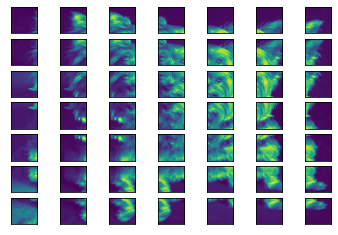

In [ ]:
for i, (images, label) in enumerate(patches_train.take(1)):
    break

fig,axes = plt.subplots(rows, cols, squeeze=False)

x = 0
for i, j, offx, offy in get_patches():
    if i >= lo and i <= hi:
        if j >= lo and j <= hi:
            patch = images[x]
            gray = np.resize(patch[0, :, :, 0], (PATCH_SIZE, PATCH_SIZE))
            axes[i,j].set_xticks([])
            axes[i,j].set_yticks([])
            axes[i,j].imshow(gray)
    x += 1

plt.show()

SIFT one image and plot descriptors

(64, 128)


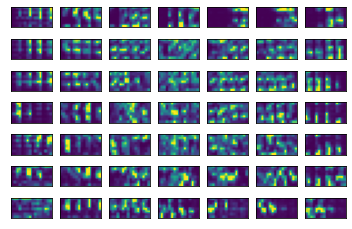

In [ ]:
input = tf.keras.Input(shape=(PATCH_SIZE, PATCH_SIZE, 1))
sift = getSIFTModel(input, num_ang_bins=NUM_ANG_BINS, num_spatial_bins=NUM_SPATIAL_BINS)
sift.compile()

pred = sift.predict(images[0])
print(pred.shape)

fig,axes = plt.subplots(rows, cols, squeeze=False)

x = 0
for i, j, offx, offy in get_patches():
    if i >= lo and i <= hi:
        if j >= lo and j <= hi:
            descriptors = sift.predict(images[x])
            gray = np.resize(descriptors[0, :], (NUM_ANG_BINS, NUM_SPATIAL_BINS*NUM_SPATIAL_BINS))
            axes[i,j].set_xticks([])
            axes[i,j].set_yticks([])
            axes[i,j].imshow(gray)
    x += 1

plt.show()

Build SIFT model

In [ ]:
def shape16(x):
    print(dir(x.shape))
    print(x.shape.as_list())
    shp = x.shape.as_list()
    return (shp[1]//(NUM_ANG_BINS*NUM_SPATIAL_BINS), 32, 1)

def reshape16(x):
    return tf.reshape(x, shape16(x))

def expand_dims(x):
    shp = x.shape.as_list()
    return (shp[1], 1)

def build_model(num_classes=NUM_CLASSES, lr=1e-3):
    inputs = []
    sifters = []
    sift = getSIFTModel(num_ang_bins=8)
    for _, _, _, _ in get_patches():
        input = tf.keras.Input(shape=(PATCH_SIZE, PATCH_SIZE, 1))
        inputs.append(input)
        sifter = sift(input)
        sifters.append(sifter)

    activation="swish" # ?
    x = tf.keras.layers.Concatenate()(sifters)
    x = tf.keras.layers.Reshape(expand_dims(x))(x)
    print('reshaped', x)
    # x = tf.keras.layers.MaxPooling1D(16, 16)(x)
    x = tf.keras.layers.AveragePooling1D(NUM_ANG_BINS*NUM_SPATIAL_BINS, NUM_ANG_BINS*NUM_SPATIAL_BINS)(x)
    print('pooled', x)
    x = tf.keras.layers.Flatten()(x)
    # x = tf.keras.layers.Activation(activation)(x) # ?
    # Idea: BinSizex1 Conv1D or Conv2D layer 

    # Add bandoneón

    # x = tf.keras.layers.Dense(1500, activation=activation)(x) # ?
    # x = tf.keras.layers.Dense(750, activation=activation)(x) # ?
    # x = tf.keras.layers.Dense(300, activation=activation)(x) # ?
    x = tf.keras.layers.Dense(NUM_CLASSES, activation=activation)(x)
    x = tf.keras.layers.Dense(NUM_CLASSES//2, activation=activation)(x)
    x = tf.keras.layers.Dense(NUM_CLASSES//4, activation=activation)(x)
    x = tf.keras.layers.Dense(NUM_CLASSES//2, activation=activation)(x)
    outputs = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")(x)

    # Compile
    # print(inputs)
    model = tf.keras.Model(inputs, outputs, name="SIFTAll")
    # optimizer = tf.keras.optimizers.Nadam(learning_rate=lr, clipvalue=1)
    optimizer = tf.keras.optimizers.Nadam(learning_rate=lr)
    # optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

# model = build_model(num_classes=NUM_CLASSES)
# model.summary()

reshaped KerasTensor(type_spec=TensorSpec(shape=(None, 6272, 1), dtype=tf.float32, name=None), name='reshape_20/Reshape:0', description="created by layer 'reshape_20'")
pooled KerasTensor(type_spec=TensorSpec(shape=(None, 196, 1), dtype=tf.float32, name=None), name='average_pooling1d/Squeeze:0', description="created by layer 'average_pooling1d'")
Model: "SIFTAll"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 65, 65, 1)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 65, 65, 1)]  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 

Train large model

In [ ]:
reset_random_seeds()
model = build_model(num_classes=NUM_CLASSES)
# model.summary()
# print(model)
# print(dir(model))

earlystopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

epochs = 80  # @param {type: "slider", min:1, max:80}
hist = model.fit(patches_train, epochs=epochs, validation_data=patches_test, 
                 verbose=2, callbacks=[earlystopping])
print('Evaluate:', model.evaluate(patches_test))


reshaped KerasTensor(type_spec=TensorSpec(shape=(None, 6272, 1), dtype=tf.float32, name=None), name='reshape_31/Reshape:0', description="created by layer 'reshape_31'")
pooled KerasTensor(type_spec=TensorSpec(shape=(None, 196, 1), dtype=tf.float32, name=None), name='average_pooling1d_1/Squeeze:0', description="created by layer 'average_pooling1d_1'")
Epoch 1/80
187/187 - 180s - loss: 4.7886 - accuracy: 0.0075 - val_loss: 4.7880 - val_accuracy: 0.0062
Epoch 2/80
187/187 - 157s - loss: 4.7841 - accuracy: 0.0095 - val_loss: 4.7756 - val_accuracy: 0.0072
Epoch 3/80
187/187 - 128s - loss: 4.6914 - accuracy: 0.0159 - val_loss: 4.6767 - val_accuracy: 0.0143
Epoch 4/80
187/187 - 157s - loss: 4.6383 - accuracy: 0.0188 - val_loss: 4.6577 - val_accuracy: 0.0142
Epoch 5/80
187/187 - 157s - loss: 4.6188 - accuracy: 0.0210 - val_loss: 4.6469 - val_accuracy: 0.0164
Epoch 6/80
187/187 - 128s - loss: 4.6067 - accuracy: 0.0230 - val_loss: 4.6401 - val_accuracy: 0.0170
Epoch 7/80
187/187 - 128s - loss: 4

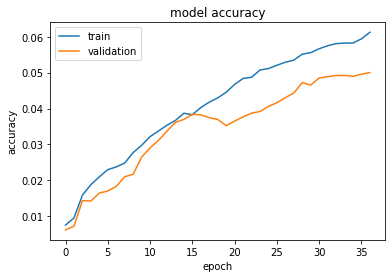

In [ ]:
import matplotlib.pyplot as plt

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

plot_hist(hist)